In [1]:
import os, sys, imp

import keras
import tensorflow as tf

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import datasets as D
imp.reload(D)

import utils as U
imp.reload(U)

import plot_lib as pl
imp.reload(pl)

import numpy as np
import datetime

from timeit import default_timer as timer

pl.set_default()

/var/folders/b9/jjp98g8j2mbcn65j0fgl0dzw0000gp/T/ipykernel_70078/294708878.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import os, sys, imp


In [2]:
# Constants
MODELDIR = "models"
BATCH_SIZE = 32
EPOCHS = 20

### Load and preprocess images

(X_train, y_train), (X_test, y_test) = D.load_cifar_data()

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [4]:
[n_train, d1, d2, c] = X_train.shape
n_test = X_test.shape[0]

nc = len(np.unique(y_train)) # number of classes
print(f"num classes: {nc}")

num classes: 10


In [5]:
# # Preprocess
# X_train = X_train / 255.0
# X_test = X_test / 255.0

In [6]:
# # Create dataset iterator
# ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# # Suhffle and batching
# ds_train = ds_train.shuffle(n_train).batch(BATCH_SIZE)
# ds_test = ds_test.batch(BATCH_SIZE)

In [7]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

ds_train = datagen.flow(X_train, y=y_train, batch_size=BATCH_SIZE, shuffle=True)
ds_test = datagen.flow(X_test, y=y_test, batch_size=BATCH_SIZE, shuffle=False)

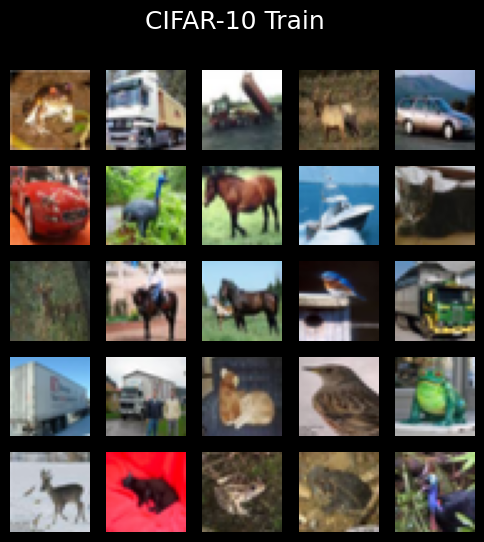

In [8]:
# Visualize dataset
U.visualize_dataset(X_train, title="CIFAR-10 Train", n_samples=25)

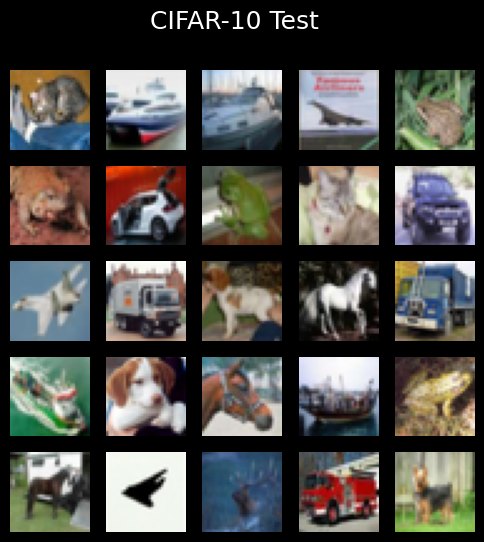

In [9]:
# Visualize dataset
U.visualize_dataset(X_test, title="CIFAR-10 Test", n_samples=25)

### Train ConvNet

Model: "convnet-cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 48)    

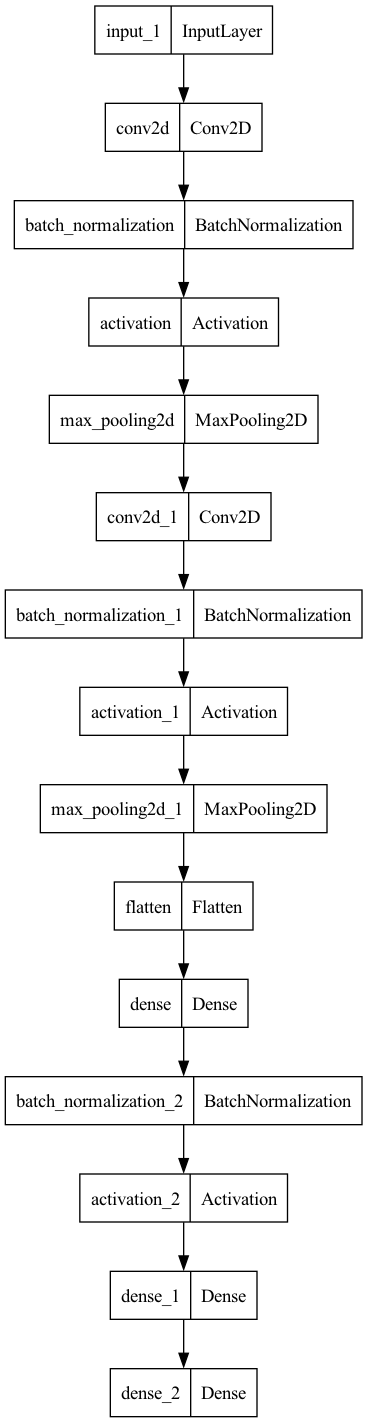

In [10]:
input_shape = (d1, d2, c)
inputs = keras.Input(shape=input_shape)
x = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(48, kernel_size=(5, 5), padding="valid")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = keras.layers.Flatten()(x)


x = keras.layers.Dense(256)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(nc)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="convnet-cifar10")
model.summary()

keras.utils.plot_model(model)

In [11]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.legacy.Adam(learning_rate=1e-4)
accuracy = keras.metrics.SparseCategoricalAccuracy()

In [12]:
# Define callbacks: Tensorboard, Model Checkpoint, Timing
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir="./logs/convnet-cifar10/" + current_time,
    update_freq="epoch"
)

checkpoint_dir = os.path.join(MODELDIR, f"convnet-cifar10-{current_time}")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_filepath = os.path.join(checkpoint_dir, "weights-{epoch:02d}-{val_loss:.2f}.hdf5")
modelcp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True
)

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

timing_callback = TimingCallback()

In [13]:
# Compile model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[accuracy],
)

In [14]:
# Train model
history = model.fit(
    ds_train,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_data=ds_test,
    callbacks=[tensorboard_callback, modelcp_callback, timing_callback]
)

Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


1563/1563 [==============================] - 25s 16ms/step - loss: 1.5385 - sparse_categorical_accuracy: 0.4520 - val_loss: 1.3707 - val_sparse_categorical_accuracy: 0.5123
Epoch 2/20
1563/1563 [==============================] - 26s 17ms/step - loss: 1.2325 - sparse_categorical_accuracy: 0.5620 - val_loss: 1.4585 - val_sparse_categorical_accuracy: 0.5001
Epoch 3/20
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1096 - sparse_categorical_accuracy: 0.6093 - val_loss: 1.1128 - val_sparse_categorical_accuracy: 0.6053
Epoch 4/20
1563/1563 [==============================] - 29s 19ms/step - loss: 1.0273 - sparse_categorical_accuracy: 0.6380 - val_loss: 1.0908 - val_sparse_categorical_accuracy: 0.6157
Epoch 5/20
1563/1563 [==============================] - 31s 20ms/step - loss: 0.9730 - sparse_categorical_accuracy: 0.6575 - val_loss: 1.0817 - val_sparse_categorical_accuracy: 0.6334
Epoch 6/20
1563/1563 [==============================] - 32s 21ms/step - loss: 0.9280 - spar

KeyboardInterrupt: 